# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/AI/eKYC_v8/

/content/drive/MyDrive/AI/eKYC_v8


# Install package

In [10]:
!pip install --quiet -r requirements.txt
!pip install --quiet ultralytics
!pip install --quiet vietocr==0.3.5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.7/876.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00


# Import Libraries

In [16]:
import os
import torch
import sys
from PIL import Image
import numpy as np
import pandas as pd
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [13]:
import crop_image
import detect_word

# Load model

In [15]:
#Load model
#Load model cropper
model_crop = YOLO('./ngu.pt')

#Load model detecter
model_detect = YOLO('./extract_info.pt')

# Load model OCR (reader)
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
config = Cfg.load_config_from_name('vgg_transformer')
config['weights'] = 'transformerocr.pth'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False

detector = Predictor(config)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Đọc ảnh

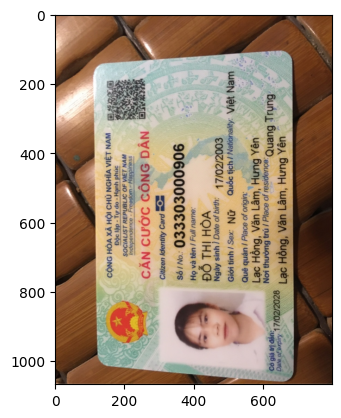

In [19]:
org_image = cv2.imread("can_cuoc.jpg")
image = org_image.copy()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Detect corners

In [20]:
results_crop = model_crop(image)
results_crop[0].boxes.xyxy


0: 640x480 1 bottom_left, 1 bottom_right, 1 top_left, 1 top_right, 708.7ms
Speed: 15.3ms preprocess, 708.7ms inference, 39.0ms postprocess per image at shape (1, 3, 640, 480)


tensor([[ 108.5530,  968.3209,  166.1064, 1026.7131],
        [  93.9921,  125.3103,  157.1847,  190.5761],
        [ 628.9175,   90.5086,  700.2065,  160.1685],
        [ 643.5377, 1020.7841,  704.2031, 1066.5417]])

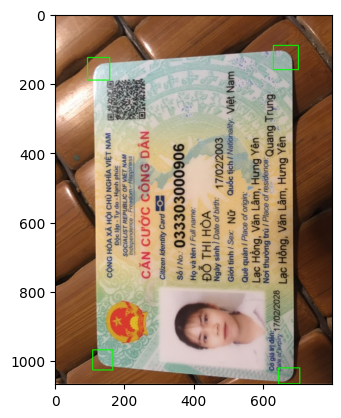

In [21]:
for box_points in results_crop[0].boxes.xyxy:
    # Convert the tensor elements to integers
    point1 = (int(box_points[0]), int(box_points[1]))
    point2 = (int(box_points[2]), int(box_points[3]))

    # Draw the rectangle on the image
    cv2.rectangle(image, point1, point2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Crop image

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 3., 1., 0.])
conf: tensor([0.7863, 0.7686, 0.6879, 0.4198])
data: tensor([[1.0855e+02, 9.6832e+02, 1.6611e+02, 1.0267e+03, 7.8629e-01, 2.0000e+00],
        [9.3992e+01, 1.2531e+02, 1.5718e+02, 1.9058e+02, 7.6859e-01, 3.0000e+00],
        [6.2892e+02, 9.0509e+01, 7.0021e+02, 1.6017e+02, 6.8786e-01, 1.0000e+00],
        [6.4354e+02, 1.0208e+03, 7.0420e+02, 1.0665e+03, 4.1980e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1067, 800)
shape: torch.Size([4, 6])
xywh: tensor([[ 137.3297,  997.5170,   57.5535,   58.3923],
        [ 125.5884,  157.9432,   63.1926,   65.2658],
        [ 664.5620,  125.3385,   71.2889,   69.6600],
        [ 673.8704, 1043.6628,   60.6654,   45.7577]])
xywhn: tensor([[0.1717, 0.9349, 0.0719, 0.0547],
        [0.1570, 0.1480, 0.0790, 0.0612],
        [0.8307, 0.1175, 0.0891, 0.0653],
        [0.8423, 0.9781, 0.0758, 0.0429]])
xyxy: tensor([[ 108.5530,  968.3209,  166.1064, 1026.713

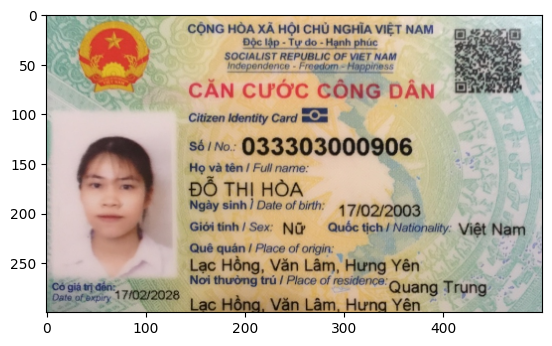

In [22]:
rcb = results_crop[0].boxes
print(rcb, len(rcb))
img_crop = crop_image.CropImg(rcb, org_image)
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))

# Detect information

In [23]:
results_detect = model_detect(img_crop)
results_detect[0].boxes.xyxy


0: 384x640 1 dob, 1 face, 1 hometown, 1 id, 1 name, 427.4ms
Speed: 7.0ms preprocess, 427.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


tensor([[  4.4149, 100.9668, 129.9941, 266.1662],
        [291.4456, 187.4760, 380.7722, 207.3587],
        [140.4554, 242.1093, 379.3668, 263.0648],
        [194.0316, 119.1770, 373.7005, 146.8394],
        [141.0608, 162.6103, 261.4325, 187.4275]])

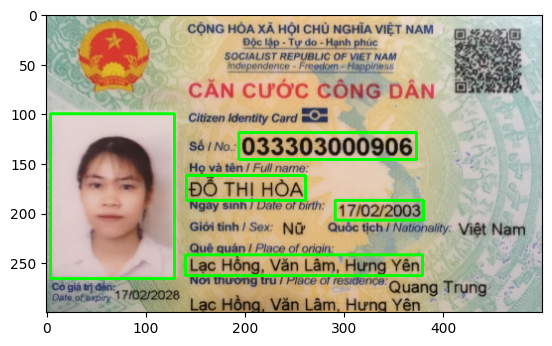

In [24]:
for box_points in results_detect[0].boxes.xyxy:
    # Convert the tensor elements to integers
    point1 = (int(box_points[0]), int(box_points[1]))
    point2 = (int(box_points[2]), int(box_points[3]))

    # Draw the rectangle on the image
    cv2.rectangle(img_crop, point1, point2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))

# Read information

In [25]:
dic = detect_word.OCR(results_detect[0].boxes, results_detect[0].names, img_crop, detector)
dic

{'face': '9',
 'hometown': 'Lạc Hồng, Văn Lâm, Hưng Yên',
 'dob': '17/02/2003',
 'name': 'ĐỖ THỊ HÒA',
 'id': '033303000906'}